# Mounting Google Drive


In [0]:
from google.colab import drive                                                        # Mounting Google drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


**Link to dataset**

https://drive.google.com/drive/folders/1vN8q2Fu189vXow1QKRDeoB7iCWqs2T_m?usp=sharing

**Please use your path to the database**

In [0]:
mypath = '/content/gdrive/My Drive/AI project/Database/'                                # File path to dataset.

# Imports 

In [0]:
import numpy as np                                                                      
import cv2                                                                              
import tensorflow as tf
import matplotlib.pyplot as plt

from glob import glob                                                                  
from joblib import Parallel, delayed                                                    
from sklearn.model_selection import train_test_split                                    
from tensorflow.keras.applications import ResNet152V2, InceptionV3 ,DenseNet121         
from tensorflow.keras.layers import  Dropout, Dense,GlobalMaxPooling2D
from sklearn.metrics import classification_report, confusion_matrix

# User Defined Functions

2 Functions are created plot_acc_loss for plotting the accuracy and loss, and read_img for reading images from disk.

In [0]:
def plot_acc_loss(result, epochs):                                    # Plotting Function           
    acc = result.history['accuracy']
    loss = result.history['loss']
    val_acc = result.history['val_accuracy']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [0]:
nprocs = 80                                         # Number of workers for parallel function

In [0]:
def read_img(filenames):                           # Read image from disk
  np.random.shuffle(filenames)
  images=Parallel(n_jobs=nprocs)(delayed(cv2.imread)(img) for img in filenames[:219])       #parallel function with cv to read image
  images_resized = [cv2.resize(img, (224,224)) for img in images]                           #Resizing images 
  return images_resized

# Reading images from drive

In [0]:
# 32 seconds from 1400 second by using parallel 

filenames = glob(mypath + 'NORMAL/' + '*.png')                                  #Normal Xrays
normal_images = read_img(filenames)                                             #Resized images stored inside a list

filenames = glob(mypath + 'COVID-19/' + '*.png')                                #COVID 
covid_images = read_img(filenames)

filenames = glob(mypath + 'Cardiomegaly/' + '*.png')                            #Cardiomegaly 
Cardiomegaly_images = read_img(filenames)

filenames = glob(mypath + 'Consolidation/' + '*.png')                           #Consolidation
Consolidation_images = read_img(filenames)

filenames = glob(mypath + 'Nodule/' + '*.png')                                  #Nodule
Nodule_images = read_img(filenames)

filenames = glob(mypath + 'Pneumonia/' + '*.png')                               #Pneumonia
Pneumonia_images = read_img(filenames)

filenames = glob(mypath + 'Pneumothorax/' + '*.png')                            #Pneumothorax
Pneumothorax_images = read_img(filenames)

Images are combined into one list, converted from uint8 to float32 and labels are assigned

In [0]:
X = np.array(normal_images + covid_images +  Cardiomegaly_images + Consolidation_images
            + Nodule_images + Pneumonia_images + Pneumothorax_images).astype('float32')/255
Y = np.array([0]*219 + [1]*219 + [2]*219 + [3]*219 + [4]*219 + [5]*219 + [6]*219  )


# Train + Validation and Testing Split

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

x_train       - Train+Val data

x_test        - Testing data  

y_train       - Train+Val labels

y_test        - Testing labels

# ResNet152V2

ResNet downloaded from internet with imagenet weights.

In [0]:
model_res_img = ResNet152V2(input_shape=(224,224,3), include_top=False, weights='imagenet')       

234553344/234545216 [==============================] - 2s 0us/step


In [0]:
model_res_img.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

Defining the Final layer

In [0]:
last_layer = model_res_img.get_layer('post_relu')                         #Geeting last layer from Resnet
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)                   

# Add a fully connected layer with  ReLU activation
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
# Add a final softmax layer for classification
x = Dense(7, activation='softmax')(x)

model_res = tf.keras.models.Model(model_res_img.input, x)
model_res.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.SGD(lr=0.001, decay=1e-6),  metrics=['accuracy'])
model_res.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

Training the ResNet with custom final layer for 30 epochs and validation is done after each epoch with a validation split of 10%

In [0]:
history_res = model_res.fit(x_train, y_train, batch_size=24, epochs=30, verbose=1, validation_split=0.1)

Epoch 1/30
52/52 [==============================] - 70s 1s/step - loss: 3.5547 - accuracy: 0.2683 - val_loss: 2.2842 - val_accuracy: 0.2246
Epoch 2/30
52/52 [==============================] - 65s 1s/step - loss: 1.8762 - accuracy: 0.3803 - val_loss: 1.5193 - val_accuracy: 0.4348
Epoch 3/30
52/52 [==============================] - 65s 1s/step - loss: 1.5029 - accuracy: 0.4609 - val_loss: 1.4758 - val_accuracy: 0.4275
Epoch 4/30
52/52 [==============================] - 65s 1s/step - loss: 1.2136 - accuracy: 0.5584 - val_loss: 1.4200 - val_accuracy: 0.4565
Epoch 5/30
52/52 [==============================] - 65s 1s/step - loss: 1.0853 - accuracy: 0.6003 - val_loss: 1.2021 - val_accuracy: 0.5797
Epoch 6/30
52/52 [==============================] - 65s 1s/step - loss: 0.9105 - accuracy: 0.6583 - val_loss: 1.1863 - val_accuracy: 0.5435
Epoch 7/30
52/52 [==============================] - 65s 1s/step - loss: 0.8170 - accuracy: 0.7147 - val_loss: 1.1053 - val_accuracy: 0.5725
Epoch 8/30
52/52 [==

Testing the model with test set

In [0]:
model_res.evaluate(x_test, y_test)

5/5 [==============================] - 3s 560ms/step - loss: 1.3384 - accuracy: 0.7013


[1.3383803367614746, 0.701298713684082]

In [0]:
y_pred = np.argmax(model_res.predict(x_test), axis = 1)

Showing the Pricision, Recall, F1 score, Confusion Matrix

In [0]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.92      0.85      0.88        27
           2       0.58      0.52      0.55        21
           3       0.48      0.67      0.56        18
           4       0.53      0.40      0.45        25
           5       0.92      1.00      0.96        24
           6       0.45      0.50      0.48        20

    accuracy                           0.70       154
   macro avg       0.70      0.70      0.69       154
weighted avg       0.71      0.70      0.70       154

[[18  0  0  0  0  1  0]
 [ 0 23  1  2  0  1  0]
 [ 0  1 11  4  4  0  1]
 [ 0  0  1 12  1  0  4]
 [ 0  1  5  2 10  0  7]
 [ 0  0  0  0  0 24  0]
 [ 0  0  1  5  4  0 10]]


1.Plotting Train & Validation Accuracy over Epochs

2.Plotting Train & Validation Loss over Epochs

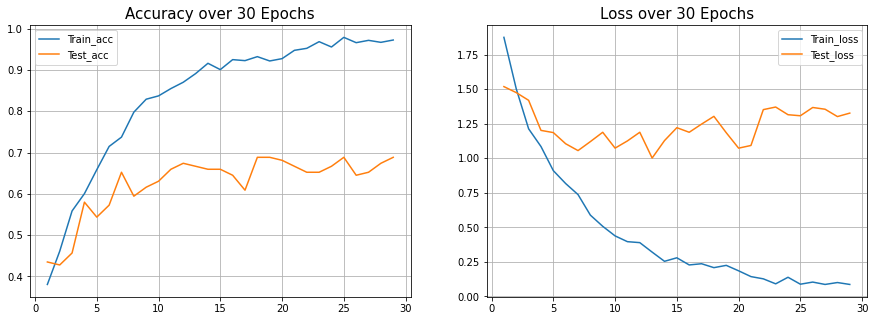

In [0]:
plot_acc_loss(history_res, len(history_res.epoch))

# InceptionV3

Inception downloaded from internet with imagenet weights.

In [0]:
model_incep_img = InceptionV3(input_shape=(224,224,3), include_top=False, weights='imagenet')

87916544/87910968 [==============================] - 1s 0us/step


In [0]:
model_incep_img.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

Defining the Final layer

In [0]:
last_layer = model_incep_img.get_layer('mixed10')                            # Getting the final layer from Inception
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)

# Add a fully connected layer with  ReLU activation
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
# Add a final softmax layer for classification
x = Dense(7, activation='softmax')(x)

model_incep = tf.keras.models.Model(model_incep_img.input, x)
model_incep.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.SGD(lr=0.001, decay=1e-6),  metrics=['accuracy'])
model_incep.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

Training the Inception with custom final layer for 30 epochs and validation is done after each epoch with a validation split of 10%

In [0]:
history_incep = model_incep.fit(x_train, y_train, batch_size=24, epochs=30, verbose=1, validation_split=0.1)

Epoch 1/30
52/52 [==============================] - 28s 534ms/step - loss: 2.3029 - accuracy: 0.1861 - val_loss: 1.8832 - val_accuracy: 0.2101
Epoch 2/30
52/52 [==============================] - 23s 433ms/step - loss: 1.7296 - accuracy: 0.3159 - val_loss: 1.6513 - val_accuracy: 0.3116
Epoch 3/30
52/52 [==============================] - 23s 434ms/step - loss: 1.5795 - accuracy: 0.3828 - val_loss: 1.5554 - val_accuracy: 0.3551
Epoch 4/30
52/52 [==============================] - 23s 434ms/step - loss: 1.4702 - accuracy: 0.4174 - val_loss: 1.4376 - val_accuracy: 0.4348
Epoch 5/30
52/52 [==============================] - 23s 433ms/step - loss: 1.3216 - accuracy: 0.4690 - val_loss: 1.3322 - val_accuracy: 0.4493
Epoch 6/30
52/52 [==============================] - 23s 433ms/step - loss: 1.2477 - accuracy: 0.5036 - val_loss: 1.3054 - val_accuracy: 0.4928
Epoch 7/30
52/52 [==============================] - 23s 433ms/step - loss: 1.1314 - accuracy: 0.5544 - val_loss: 1.2720 - val_accuracy: 0.5000

Testing the model with test set

In [0]:
model_incep.evaluate(x_test, y_test)

5/5 [==============================] - 2s 350ms/step - loss: 1.0830 - accuracy: 0.6948


[1.0829660892486572, 0.6948052048683167]

In [0]:
y_pred = np.argmax(model_incep.predict(x_test), axis = 1)

Showing the Pricision, Recall, F1 score, Confusion Matrix

In [0]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       0.96      0.89      0.92        27
           2       0.64      0.76      0.70        21
           3       0.53      0.56      0.54        18
           4       0.44      0.28      0.34        25
           5       0.92      0.92      0.92        24
           6       0.38      0.50      0.43        20

    accuracy                           0.69       154
   macro avg       0.69      0.69      0.69       154
weighted avg       0.70      0.69      0.69       154

[[18  0  0  0  0  1  0]
 [ 0 24  0  0  1  1  1]
 [ 0  0 16  2  2  0  1]
 [ 0  0  2 10  1  0  5]
 [ 0  0  6  3  7  0  9]
 [ 1  1  0  0  0 22  0]
 [ 0  0  1  4  5  0 10]]


1.Plotting Train & Validation Accuracy over Epochs

2.Plotting Train & Validation Loss over Epochs

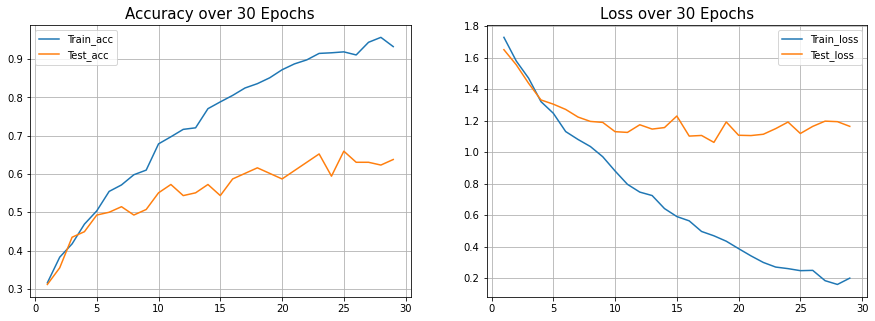

In [0]:
plot_acc_loss(history_incep, len(history_incep.epoch))

#DenseNet121

DenseNet downloaded from internet with imagenet weights.

In [0]:
model_dense_img = DenseNet121(input_shape=(224,224,3), include_top=False, weights='imagenet')

29089792/29084464 [==============================] - 0s 0us/step


In [0]:
model_dense_img.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

Defining the Final layer

In [0]:
last_layer = model_dense_img.get_layer('relu')                        # Last layer from DenseNet
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)

# Add a fully connected layer with  ReLU activation
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
# Add a final softmax layer for classification
x = Dense(7, activation='softmax')(x)

model_dense = tf.keras.models.Model(model_dense_img.input, x)
model_dense.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.SGD(lr=0.001, decay=1e-6),  metrics=['accuracy'])
model_dense.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

Training the DenseNet with custom final layer for 30 epochs and validation is done after each epoch with a validation split of 10%

In [0]:
history_dense = model_dense.fit(x_train, y_train, batch_size=24, epochs=30, verbose=1, validation_split=0.1)

Epoch 1/30
52/52 [==============================] - 34s 647ms/step - loss: 2.6957 - accuracy: 0.2603 - val_loss: 1.8406 - val_accuracy: 0.2899
Epoch 2/30
52/52 [==============================] - 27s 526ms/step - loss: 1.6893 - accuracy: 0.3723 - val_loss: 1.6460 - val_accuracy: 0.4203
Epoch 3/30
52/52 [==============================] - 27s 524ms/step - loss: 1.3717 - accuracy: 0.4843 - val_loss: 1.5752 - val_accuracy: 0.3696
Epoch 4/30
52/52 [==============================] - 27s 526ms/step - loss: 1.2084 - accuracy: 0.5463 - val_loss: 1.4540 - val_accuracy: 0.4348
Epoch 5/30
52/52 [==============================] - 27s 526ms/step - loss: 1.1003 - accuracy: 0.5818 - val_loss: 1.3534 - val_accuracy: 0.4638
Epoch 6/30
52/52 [==============================] - 27s 525ms/step - loss: 0.9982 - accuracy: 0.6148 - val_loss: 1.3213 - val_accuracy: 0.5072
Epoch 7/30
52/52 [==============================] - 27s 525ms/step - loss: 0.8631 - accuracy: 0.6833 - val_loss: 1.1763 - val_accuracy: 0.5362

Testing the model with test set

In [0]:
model_dense.evaluate(x_test, y_test)

5/5 [==============================] - 2s 406ms/step - loss: 1.0588 - accuracy: 0.6429


[1.0588226318359375, 0.6428571343421936]

In [0]:
y_pred = np.argmax(model_dense.predict(x_test), axis = 1)

Showing the Pricision, Recall, F1 score, Confusion Matrix

In [0]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        19
           1       0.77      0.89      0.83        27
           2       0.47      0.38      0.42        21
           3       0.52      0.61      0.56        18
           4       0.33      0.32      0.33        25
           5       0.89      1.00      0.94        24
           6       0.41      0.35      0.38        20

    accuracy                           0.64       154
   macro avg       0.63      0.64      0.63       154
weighted avg       0.63      0.64      0.63       154

[[17  1  0  0  0  1  0]
 [ 0 24  0  0  1  2  0]
 [ 0  3  8  3  4  0  3]
 [ 0  0  0 11  5  0  2]
 [ 0  1  8  3  8  0  5]
 [ 0  0  0  0  0 24  0]
 [ 0  2  1  4  6  0  7]]


1.Plotting Train & Validation Accuracy over Epochs

2.Plotting Train & Validation Loss over Epochs

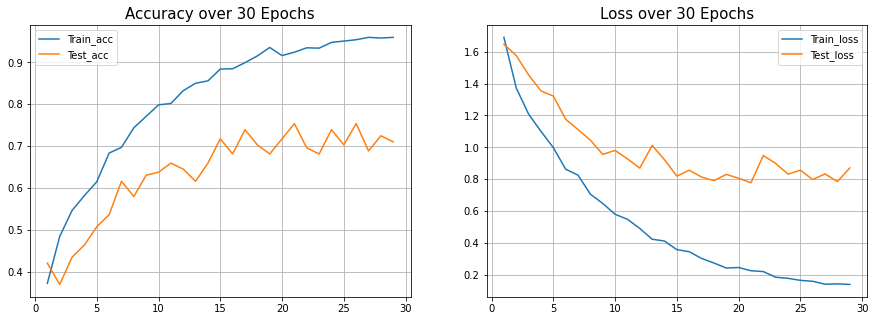

In [0]:
plot_acc_loss(history_dense, len(history_dense.epoch))